# Nanosilica Optimization


This is a demo of  summit, a tool for optimizing chemical processes.  The data is from optimization of the nanomaterial nanosilica. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from summit.data import DataSet
from summit.domain import ContinuousVariable, Constraint, Domain
from summit.strategies import TSEMO2
from summit.models import GPyModel, AnalyticalModel
from summit.utils import pareto_efficient

from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d

## 1. Set up problem

To start, we import a CSV file with existing experimental data. The last 5 experiments are also displayed.

Since we  want to target a specific value for STD, we need to calculate that distance.

In [45]:
#Read in and clean up data
data_pd = pd.read_csv('silica_experiments_data.csv')
input_columns = [ 'TEOS', 'NH3', 'H2O', 'EtOH']
output_columns = ['PSD', 'STD']
metadata_columns=['Batch']
data_pd = data_pd[input_columns + output_columns + metadata_columns]

#Transform
data_pd['PSD_distance_100'] = ((data_pd['PSD']-100)**2)**0.5

data = DataSet.from_df(data_pd, metadata_columns=metadata_columns)
data.tail(5)

,TEOS,NH3,H2O,EtOH,PSD,STD,Batch,PSD_distance_100
40,7.426,71.5304,13.3553,7.6883,253.10,52.22,3.0,153.10
41,6.500,21.1000,48.2000,24.2000,209.50,44.09,4.0,109.50
42,6.700,20.0000,68.5000,4.8000,8.30,2.37,4.0,91.70
43,2.000,45.4000,50.6000,2.0000,14.81,3.86,4.0,85.19
44,1.530,90.1200,7.9500,0.4000,24.51,7.71,4.0,75.49


Here we set up the optimization domain, which consists of the manipulated variables, optimization objectives and constraints.

In [46]:
#Set up the optimization problem domain
domain = Domain()

#Decision variables
domain += ContinuousVariable('TEOS', 
                             description = '',
                             bounds=[1, 35])
domain += ContinuousVariable('NH3', 
                             description = '',
                             bounds=[0, 100])
domain += ContinuousVariable('H2O', 
                             description = '',
                             bounds=[0, 100])
# domain += ContinuousVariable('EtOH', 
#                              description = '',
#                              bounds=[0, 100])
#Objectives
domain += ContinuousVariable('PSD_distance_100', 
                             description = 'Distance of average particle size from target of 100',
                             bounds=[0, 1000],
                             is_objective=True,
                             maximize=False)
domain += ContinuousVariable('STD', 
                             description = 'Standard deviation of particle size distribution',
                             bounds=[0, 1000],
                             is_objective=True,
                             maximize=False)

#Constraints
domain += Constraint(lhs='TEOS+NH3+H2O-100',
                     constraint_type='<')
domain += Constraint(lhs='(H2O+0.75*0.91*NH3)/18-2*TEOS/208.33',
                     constraint_type='>')

domain

Name,Type,Description,Values
TEOS,"continuous, input",,"[1,35]"
NH3,"continuous, input",,"[0,100]"
H2O,"continuous, input",,"[0,100]"
PSD_distance_100,"continuous, minimize objective",Distance of average particle size from target of 100,"[0,1000]"
STD,"continuous, minimize objective",Standard deviation of particle size distribution,"[0,1000]"
,constraint,TEOS+NH3+H2O-100,
,constraint,(H2O+0.75*0.91*NH3)/18-2*TEOS/208.33,


## 2. Visualize Data

Let's visualize the data now.  Here we show the approximate pareto front based on existing experimental data. There appears to be a trade off between cost and  viscosity.

<Figure size 432x288 with 0 Axes>

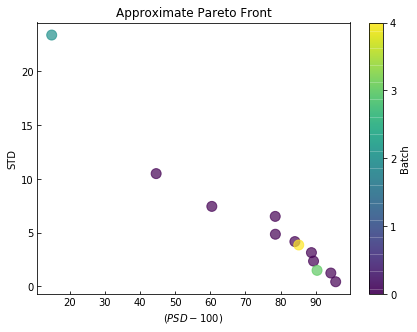

In [51]:
_ = plt.tight_layout()
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
pareto_front, indices = pareto_efficient(data[['PSD_distance_100', 'STD']].to_numpy(),
                                         maximize=False)
# ax.scatter(data['PSD_target'], data['STD'],
#            alpha=0.5, label='all data', marker='^', s=50)
img =ax.scatter(pareto_front[:, 0], pareto_front[:, 1],
                alpha=0.7, label='pareto front', s=100,
                c=data.reindex(indices)['Batch'].astype(int))
_ = plt.colorbar(img, label='Batch', ticks=[0, 1, 2, 3, 4])
ax.set_xlabel(r'$(PSD-100)$'); ax.set_ylabel('STD');
ax.tick_params(direction='in')
_ = ax.set_title('Approximate Pareto Front')

In [52]:
print("Pareto Front Experiments")
data.reindex(indices)

Pareto Front Experiments


,TEOS,NH3,H2O,EtOH,PSD,STD,Batch,PSD_distance_100
0,1.0000,5.0000,94.0000,0.0000,5.68,1.250,0.0,94.32
1,1.0000,10.0000,89.0000,0.0000,21.46,4.860,0.0,78.54
2,1.0000,20.0000,79.0000,0.0000,39.54,7.450,0.0,60.46
3,1.0000,30.0000,69.0000,0.0000,55.38,10.500,0.0,44.62
6,5.0000,30.0000,65.0000,0.0000,11.20,3.150,0.0,88.80
8,10.0000,20.0000,70.0000,0.0000,10.60,2.360,0.0,89.40
10,10.0000,40.0000,50.0000,0.0000,21.50,6.520,0.0,78.50
13,1.0000,1.0000,98.0000,0.0000,4.30,0.440,0.0,95.70
22,1.0200,32.9100,45.7700,20.3000,15.91,4.176,0.0,84.09
35,5.3252,70.3309,17.9582,6.3857,114.90,23.390,2.0,14.90


## 3. Run Optimization

Now, we can run the optimization, asking for 3 experimental suggestions.

In [39]:
num_experiments=4
input_dim = domain.num_continuous_dimensions() + domain.num_discrete_variables()
models = {'PSD_distance_100': GPyModel(input_dim=input_dim), 
          'STD': GPyModel(input_dim=input_dim)
         }
tsemo = TSEMO2(domain, models)
experiments = tsemo.generate_experiments(data, num_experiments)
experiments['EtOH'] = 100-(experiments['TEOS'] + experiments['NH3'] + experiments['H2O'])
experiments.round()

,TEOS,NH3,H2O,PSD_target,STD,EtOH
127,16.0,30.0,53.0,40.0,14.0,2.0
40,1.0,24.0,71.0,70.0,5.0,4.0
71,16.0,5.0,78.0,89.0,2.0,1.0
253,11.0,7.0,68.0,57.0,10.0,14.0


We now have experimental suggestions that we can run in the lab.

## 4. Validate Model

We'll make a cross validation plot next. This gives us a sense of model robustness. So far, it seems that the model has a very good accuracy in one part of the space, but not great accuracy elsewhere. 

Note that the graph on the left is the distance of average particle size from target of 100


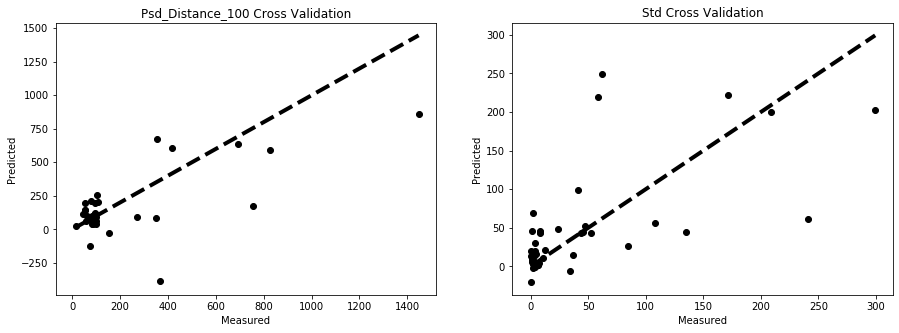

In [54]:
gp = GPyModel(input_dim=input_dim)
X = data[['NH3', 'TEOS', 'H2O']].to_numpy(dtype=np.float64)
Y = data[output_columns].to_numpy(dtype=np.float64)


fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, name in enumerate(['PSD_distance_100', 'STD']):
    kf = KFold(n_splits=3)
    scores = np.zeros(5)

    Y = data[name].to_numpy(dtype=np.float64)
    for train, test in kf.split(X):
        gp.fit(X[train], np.atleast_2d(Y[train]).T)
        y_predict = gp.predict(X[test])
        axes[i].scatter(Y[test], y_predict, c='k')
    min_y = Y.min()
    max_y = Y.max()
    axes[i].plot([min_y, max_y], [min_y, max_y], 'k--', lw=4)
    axes[i].set_xlabel('Measured')
    axes[i].set_ylabel('Predicted')
    axes[i].set_title(f'{name} Cross Validation'.title())
print("Note that the graph on the left is the distance of average particle size from target of 100")